In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/global/homes/j/jderose/desi/users/jderose/aemulus_heft/')
import json
import numpy as np
from aemulus_heft.heft_emu import HEFTEmulator, NNHEFTEmulator
from aemulus_heft.utils import lpt_spectra
from scipy.interpolate import interp1d
from glob import glob

plt.rcParams['figure.figsize']        = 10., 10.
plt.rcParams['figure.dpi']            = 100
plt.rcParams['figure.subplot.left']   = 0.125
plt.rcParams['figure.subplot.right']  = 0.9
plt.rcParams['figure.subplot.bottom'] = 0.125
plt.rcParams['figure.subplot.top']    = 0.9
plt.rcParams['axes.labelsize']        = 16
plt.rcParams['axes.titlesize']        = 16
plt.rcParams['xtick.top']             = True
plt.rcParams['xtick.bottom']          = True
plt.rcParams['ytick.left']            = True
plt.rcParams['ytick.right']           = True
plt.rcParams['xtick.direction']       = 'in'
plt.rcParams['ytick.direction']       = 'in'
plt.rcParams['xtick.labelsize']       = 16
plt.rcParams['ytick.labelsize']       = 16
plt.rcParams['xtick.major.pad']       = 6.
plt.rcParams['xtick.minor.pad']       = 6.
plt.rcParams['ytick.major.pad']       = 6.
plt.rcParams['ytick.minor.pad']       = 6.
plt.rcParams['xtick.major.size']      = 6. # major tick size in points
plt.rcParams['xtick.minor.size']      = 3. # minor tick size in points
plt.rcParams['ytick.major.size']      = 6. # major tick size in points
plt.rcParams['ytick.minor.size']      = 3. # minor tick size in points
plt.rcParams['text.usetex']           = True
plt.rcParams['font.family']           = 'serif'
plt.rcParams['font.size']             = 16

In [13]:
# Compute KECLEFT spectra to use as inputs for HEFT emulator
# (ombh2, omch2, w0, ns, 10^9 As, H0, mnu)
cosmo = [0.0223, 0.12, -1, 0.97, 2.1, 67, 0.06]
k = np.logspace(-2, np.log10(4), 100)
spec_lpt, sigma8z = lpt_spectra(k, 0, cosmo)

In [14]:
# Feed KECLEFT spectra, and cosmology with sigma8(z) appended to it to HEFTEmulator
emu = HEFTEmulator()
cosmo.append(sigma8z)
spec_heft = emu.predict(k, np.array(cosmo), spec_lpt)

In [18]:
# append redshift to the end of the cosmology vector
cosmo = [0.0223, 0.12, -1, 0.97, 2.1, 67, 0.06, 0]
nnemu = NNHEFTEmulator()
k_nn, spec_heft_nn = nnemu.predict(np.atleast_2d(cosmo))

/tmp/ipykernel_200284/115566108.py:25: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[0][0].set_xlim([0,1])


(0.0006605367730498035, 1)

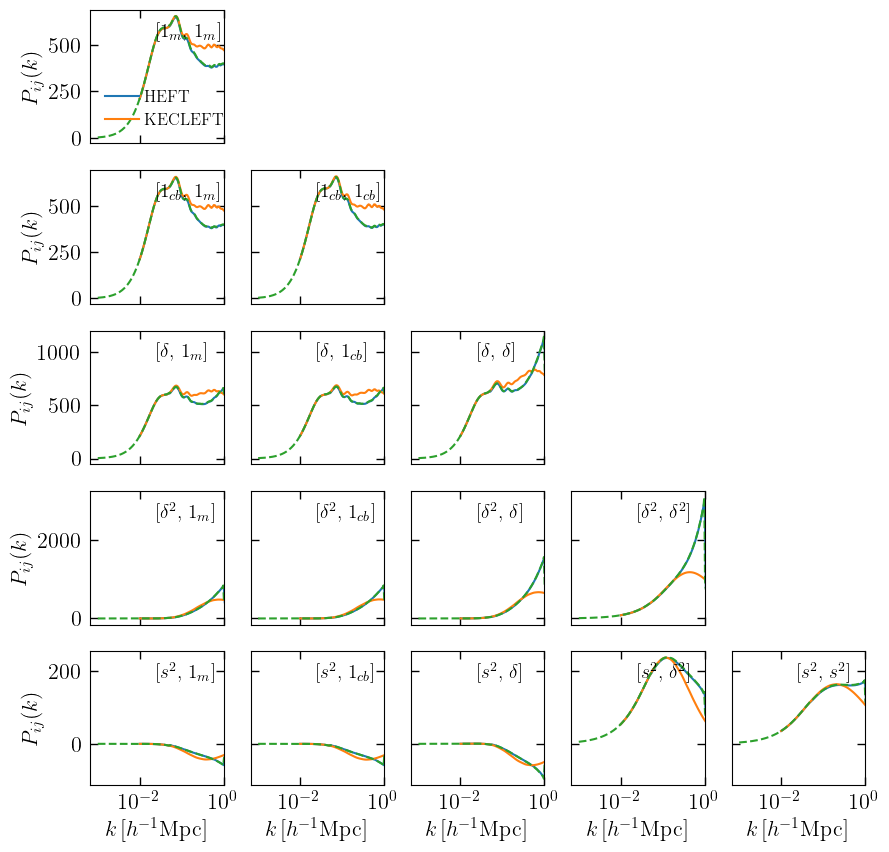

In [17]:
f, ax = plt.subplots(5,5, sharex=True, sharey='row')
fields = [r'$1_{m}$', r'$1_{cb}$', r'$\delta$', r'$\delta^2$', r'$s^2$']

counter = 0
for i in range(5):
    for j in range(5):
        if (j>i):
            ax[i,j].axis('off')
            continue
        ax[i,j].semilogx(k, k * spec_heft[counter,:], c='C0')
        ax[i,j].semilogx(k, k * spec_lpt[counter,:], c='C1')
        ax[i,j].semilogx(k_nn[:-1], k_nn[:-1] * spec_heft_nn[0,counter,:-1], c='C2', ls='--')
        
        ax[i,j].text(0.5, 0.8, r'[{}, {}]'.format(fields[i], fields[j]), fontsize=14, transform=ax[i,j].transAxes)
        
        counter += 1
        
        if i==4:
            ax[i,j].set_xlabel(r'$k\, [h^{-1} \rm Mpc]$')

        if j==0:
            ax[i,j].set_ylabel(r'$P_{ij}(k)$') 
            
ax[0][0].legend([r'HEFT', r'KECLEFT'], fontsize=12)
ax[0][0].set_xlim([0,1])
        

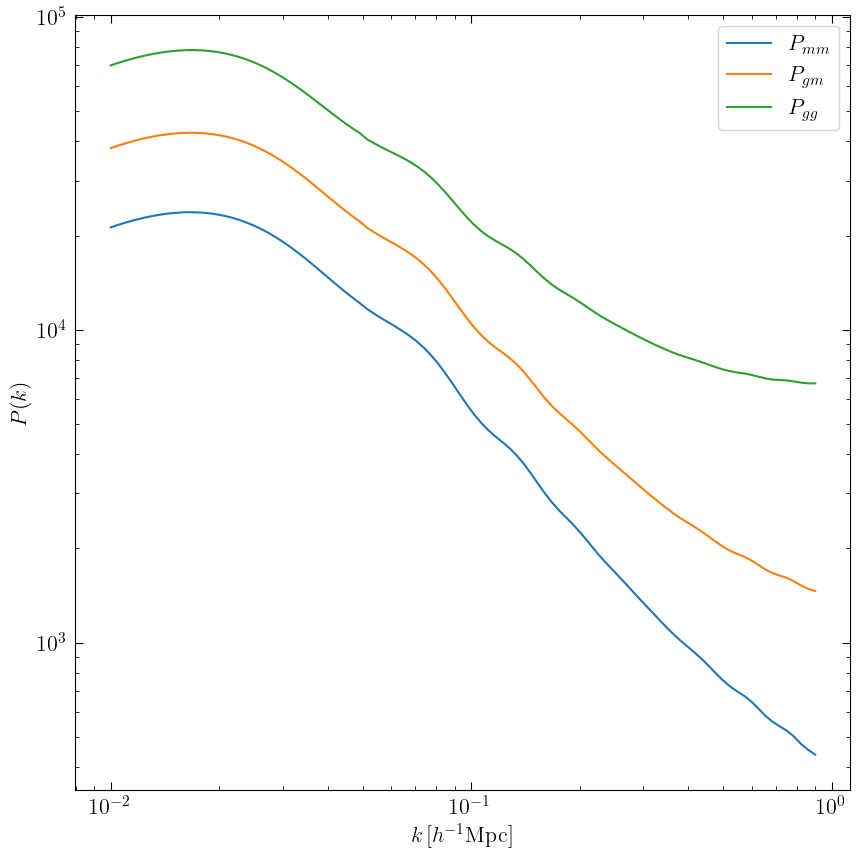

In [36]:
bvec = [0.786, 0.583, -0.406, -0.512, 1755]

P_gg = emu.basis_to_full(k, bvec, spec_heft, cross=False)
P_gm = emu.basis_to_full(k, bvec, spec_heft)
P_mm = spec_heft[0,:]

plt.loglog(k, P_mm)
plt.loglog(k, P_gm)
plt.loglog(k, P_gg)

P_gg = nnemu.basis_to_full(k_nn, bvec, spec_heft, cross=False)
P_gm = nnemu.basis_to_full(k_nn, bvec, spec_heft)
P_mm = spec_heft[0,:]

plt.xlabel(r'$k\, [h^{-1} \rm Mpc]$')
plt.ylabel(r'$P(k)$') 
plt.legend([r'$P_{mm}$', r'$P_{gm}$', r'$P_{gg}$'])

In [5]:
with open('../aemulus_heft/data/error_cov.json', 'r') as fp:
    error_cov = json.load(fp)

In [6]:
cov = np.array(error_cov['eps_ij_cov_tier2'])

In [7]:
cov_heft = emu.error_covariance(spec_heft, k, 0, cov)

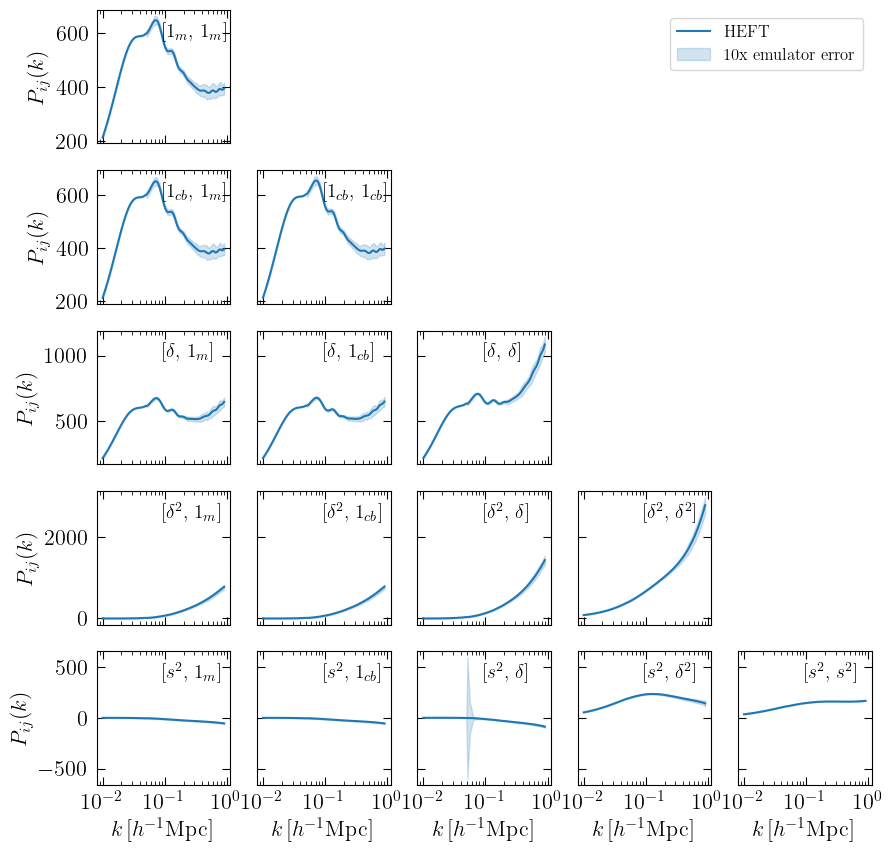

In [8]:
f, ax = plt.subplots(5,5, sharex=True, sharey='row')
fields = [r'$1_{m}$', r'$1_{cb}$', r'$\delta$', r'$\delta^2$', r'$s^2$']

counter = 0
for i in range(5):
    for j in range(5):
        if (j>i):
            ax[i,j].axis('off')
            continue
        l0=ax[i,j].semilogx(k, k * spec_heft[counter,:], c='C0')
        l1=ax[i,j].fill_between(k, k * (spec_heft[counter,:] + 10*np.sqrt(np.diag(cov_heft[counter,:,:]))),
                             k * (spec_heft[counter,:] - 10*np.sqrt(np.diag(cov_heft[counter,:,:]))), color='C0', alpha=0.2)
        ax[i,j].text(0.5, 0.8, r'[{}, {}]'.format(fields[i], fields[j]), fontsize=14, transform=ax[i,j].transAxes)
        
        counter += 1
        
        if i==4:
            ax[i,j].set_xlabel(r'$k\, [h^{-1} \rm Mpc]$')

        if j==0:
            ax[i,j].set_ylabel(r'$P_{ij}(k)$') 

ax[0][4].legend([l0[0],l1], [r'HEFT', r'10x emulator error'], fontsize=12)
        